## Кластеризация

Кластеризация - задача разбиения объектов на группы (кластеры). Кластеризация в отличие от регрессии и классификации не использует правильные ответы при обучении, поэтому это задача обучения без учителя. 

Основное предположение в кластеризации - объекты, близкие в признаковом пространстве, близки на самом деле. Все алгоритмы кластеризации так или иначе вычисляют близость между объектами (это может быть, например, косинусное расстояние) и стараются организовать кластеры так, чтобы между объектами одного кластера было небольшое расстояние.

Так как считать близости между всеми объектами может быть долго, данные могут распологаться в пространстве странным образом (без четких границ, например) или иметь выбросы, в конкретных алгоритмах кластеризации используются дополнительные предположения и разные трюки. Часто к ним привязывается гиперпараметр(ы), который нужно настраивать самому. Сделать это обычно непросто из-за того, что у нас нет конкретного критерия качества, а сами параметры могут быть непонятными. 

Есть метрики, которые оценивают качество кластеризации по каким-то внутренним критериям. Также есть способы оценивать качество кластеризации с использованием правильных ответов*. Однако они не всегда коррелируют с тем, что мы хотим получить и приходится оценивать просто на глаз.

\* У вас может возникнуть вопрос - а зачем использовать кластеризацию, когда есть правильные ответы? Это может быть нужно, когда размеченных данных мало относительно общего количества имеющихся данных. В классификации и регрессии мы смогли бы использовать только размеченную часть, а кластеризацию мы можем обучить на всех данных, проверив качество на размеченном куске.

Давайте попробуем кластеризовать заголовки объявлений на Авито, чтобы нагляднее увидеть сложности кластеризации.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('clustering/data.csv')

In [6]:
data.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,793dd3d5f0f0,9467e0341c0e,Алтайский край,Барнаул,Личные вещи,Детская одежда и обувь,Для девочек,Платья и юбки,146-152 см (10-12 лет),Платье праздничное для девочки,Очень красивое торг,1500.0,106,2017-04-12,Company,ace7b2b7f066a6b6ff244f90d030c2c1a1bf118dd0e1ac...,573.0
1,f8c965d9b668,1905516660f5,Свердловская область,Каменск-Уральский,Для дома и дачи,Мебель и интерьер,"Кровати, диваны и кресла",NaN,NaN,Кровать двухспальная,Двуспальная кровать 140х200 с металлическим ка...,5700.0,10,2017-04-15,Private,b38ef24dd5b876ed626bd98241e228e4e19e4160d33abe...,1439.0
2,2f153c00d561,b4dc4849fdd4,Самарская область,Самара,Бытовая электроника,Телефоны,Samsung,NaN,NaN,Samsung S3 mini gt-i8190,"Продам телефон самсунг 2 ядра, 1 гиг оперативн...",1500.0,6,2017-04-12,Private,8530cc0c8d5dc6d212497dffd610d89b92a7db952934db...,2932.0
3,7fc5eea56915,02c14d39fdb4,Саратовская область,Саратов,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,44–46 (M),"Красивое платье на одно плечо, в идеале размер м","Заказывала в Сша, прекрасное качество, в деле ...",1000.0,1280,2017-04-13,Company,eb21745ba276d3b00b05856a58fe719e31a82419c0221a...,386.0
4,b01000d29ea3,b17f14110367,Удмуртия,Ижевск,Личные вещи,Детская одежда и обувь,Для мальчиков,"Шапки, варежки, шарфы",NaN,Стильная панама,Состояние новой. Размер до года- полтора. По ...,150.0,145,2017-04-14,Company,5bf1001fa681b96f121ad8047c85e3747f3dac37830dd0...,209.0


Возьмем ещё название категорий, чтобы попробовать через него оценивать качетство кластеризации.

In [3]:
data = data[['category_name', 'title']]

In [4]:
data.shape

(254219, 2)

In [4]:
pd.set_option('display.max_rows', 500)

#### Импотируем разные алгоритмы кластеризации и метрики 

In [5]:
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN, \
                            KMeans, MiniBatchKMeans, Birch, MeanShift, SpectralClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, \
                            silhouette_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.datasets import make_blobs

## AffinityPropagation

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/publication/275558354/figure/fig12/AS:669589163745280@1536653905013/Affinity-propagation-demo-18.png")

В AP хитрым образом ищутся "экземпляры", объекты в выборке которые могут использоваться как прототипы. Ближайшие к прототипам объекты записываются в этот кластер.

Приемущества AP - не нужно подбирать количество кластеров.  
Недостатки - медленно и тратится много памяти, параметры не очевидные.

AffinityPropagation не очень с большими дасетами (10к + строчек), поэтому сделаем подвыборку

In [11]:
# можно переопределить датасет его частью
sample = data.sample(frac=0.01)

In [12]:
sample.shape

(2542, 2)

С векторизацией пока не будем заморачиваться

In [13]:
cv = CountVectorizer(max_features=500)
X = cv.fit_transform(sample['title'])

y = sample['category_name']

In [14]:
X.shape

(2542, 500)

У AP два основных параметра - damping и preference. Второй влияет на количество находимых экземпляров (чем выше значение, тем больше кластеров). Первый не очень понятный, его нужно ставить от 0.5 до 1. Ещё можно поставить max_iter побольше 200, если пишет, что не сошлось.

In [15]:
cluster = AffinityPropagation(damping=0.7, preference=-5, 
                              max_iter=400, verbose=2)
cluster.fit(X)

Converged after 166 iterations.


AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.7, max_iter=400, preference=-5, verbose=2)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [16]:
labels = cluster.labels_

Посмотрим сколько кластеров образовалось

In [17]:
n_clusters = len(set(labels))

In [18]:
len(set(labels))

142

Давайте попробуем посчитать метрики 

Основная внутренняя метрика - силуэты. Она считает насколько близки объекты внутри кластера, а также насколько объекты одного кластера далеко от другого кластера.

In [19]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.280


Метрики с учётом правильных ответов (в нашем случае категории). Подробно мы их разбирать не будем, основная идея всех метрик - сравнить разбиения без привязки к конкретным меткам. Для этого так или иначе используется информация о том, какие объекты относятся к одному классу и одному кластеру, и какие объекты относятся к разным классам и разным кластерам.

Про метрики можно почитать тут - https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html

In [20]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.443
Completeness: 0.379
V-measure: 0.409
Adjusted Rand Index: -0.015
Adjusted Mutual Information: 0.277


Сложно сказать, насколько хорошие или плохие это числа. Давайте попробуем посмотреть глазами

In [6]:
sample['cluster'] = cluster.labels_

NameError: name 'cluster' is not defined

In [22]:
sample[sample.cluster==15].head(10)

,category_name,title,cluster
49792,Аудио и видео,Портативный dvd,15
90951,Аудио и видео,DVD fusion fd-u148x,15
62613,Аудио и видео,DVD video player,15
36081,Аудио и видео,DVD плеер ввк,15
200621,Аудио и видео,DVD диски,15


## AgglomerativeClustering

In [22]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.datanovia.com/en/wp-content/uploads/dn-tutorials/003-hierarchical-clustering-in-r/figures/002-agglomerative-clustering-cutree-cut-dendrogram-1.png")


В агломеративной кластеризации каждому объекту припывается свой кластер и потом ближайшие кластеры постепенно объединяются, пока не получится 1 кластер или не получится количество, заданное как параметр. 

Когда рассказывают про этот вид кластеризации обычно рисуют вот такие картинки. Предполагается, что можно посмотреть на то, как объекты постепенно соединяются и найти оптимальное количество кластеров. Однако это сработает только на небольшом количестве объектов, больше 100 объектов нарисовать будет очень сложно.

Этот вид кластеризации может обработать немного побольше данных

In [23]:
sample = data.sample(frac=0.05)

In [24]:
sample.shape

(12711, 2)

Аггломеративная кластеризация не умеет работать с sparse матрицами, можно понизить размерность через svd

In [25]:
cv = CountVectorizer(max_features=500)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [26]:
len(y.unique())

46

In [27]:
X.shape

(12711, 500)

In [28]:
# так как визуально мы не может найти оптимальное количество кластеров, придется подбирать
# поставим число категорий
cluster = AgglomerativeClustering(n_clusters=170)
cluster.fit(X_svd)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=170)

In [29]:
len(set(cluster.labels_))

170

In [30]:
labels = cluster.labels_

Давайте попробуем посчитать метрики 

In [31]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.264


In [32]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.378
Completeness: 0.356
V-measure: 0.367
Adjusted Rand Index: 0.005
Adjusted Mutual Information: 0.323


In [33]:
sample['cluster'] = cluster.labels_

Можно проанализировать сколько разных категорий намешалось в один кластер (тем меньше, тем лучше)

In [34]:
sample[sample.category_name=='Телефоны'].cluster.value_counts()

140    226
82      71
50      42
16      34
9       31
133     27
12      20
21      18
19      16
75      12
24      10
67      10
96      10
110      7
125      7
144      5
61       4
37       3
97       3
130      3
84       2
83       1
53       1
52       1
27       1
22       1
139      1
145      1
Name: cluster, dtype: int64

## Mean Shift

In [35]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/publication/326242239/figure/fig3/AS:645578044231681@1530929208053/Intuitive-description-of-the-mean-shift-procedure-find-the-densest-regions-in-the.png")


MS ищет плотные скопления объектов и ставит там кружочки определеного размера. Все, что попадает в кружочек, относится к кластеру. Количество кластеров задавать не нужно. 

Это первый их рассмотренных алгоритмов, который не относит к кластерам все объекты.

In [35]:
sample = data.sample(frac=0.01)

In [36]:
sample.shape

(2542, 2)

MS тоже не умеет работать с sparse матрицами

In [37]:
cv = CountVectorizer(max_features=2000)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [38]:
# bandwidth - как раз рамер этого кружка, но его сложно подбирать самому, т.к. в каждой задаче он будет свой
# вот так можно узнать, что будет по умолчанию и начать с этого значения, постепенно уменьшая или увеличивая
import sklearn
sklearn.cluster.estimate_bandwidth(X_svd)

0.7566217525889855

In [39]:
# cluster_all=False чтобы не записывать все объекты в кластеры
cluster = MeanShift(cluster_all=False, bandwidth=0.5)
cluster.fit(X_svd)

MeanShift(bandwidth=0.5, bin_seeding=False, cluster_all=False, max_iter=300,
          min_bin_freq=1, n_jobs=None, seeds=None)

Посмотрим сколько кластеров образовалось

In [40]:
len(set(cluster.labels_))

258

In [41]:
labels = cluster.labels_

In [42]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.004


In [43]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.375
Completeness: 0.363
V-measure: 0.369
Adjusted Rand Index: -0.008
Adjusted Mutual Information: 0.218


In [44]:
sample['cluster'] = cluster.labels_

Алгоритмы кластеризация, которые умеют отфильтровывать выбросы, приписывают им -1 кластер.

In [45]:
# так мы можем оценить, действительно ли отсеивается мусор или мы просто недокластеризуем
sample[sample.cluster==-1].head()

,category_name,title,cluster
129626,Автомобили,"ГАЗ ГАЗель 33023, 2011",-1
235121,Автомобили,"ГАЗ ГАЗель 3302, 1999",-1
51653,"Дома, дачи, коттеджи",Дом 80 м² на участке 25 сот.,-1
73924,Ремонт и строительство,"Раковина: market M 55 B 1 отв., белый, 56*46",-1
29621,Детская одежда и обувь,Нарядное платье на девочку 3-4 года,-1


## Spectral Clustering

В SC перед тем как кластерозовать к объектам применяется какое-то преобразование. Это преобразование должно приводить странно организованные в пространстве объекты к более стандартному виду, который могут переварить простые алгоритмы кластеризации (по дефолту используется KMEANS - про него немного ниже)

Так как кластируется через kmeans нужно подбирать количество кластеров самому.

In [46]:
sample = data.sample(frac=0.01)

In [47]:
sample.shape

(2542, 2)

Аггломеративная кластеризация не умеет работать с sparse матрицами, можно понизить размерность через svd

In [48]:
cv = CountVectorizer(max_features=500)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [49]:
X.shape

(2542, 500)

In [50]:
cluster = SpectralClustering(n_clusters=47)
cluster.fit(X_svd)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=47, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [51]:
cluster.labels_

array([ 0,  0,  0, ..., 20, 30,  0], dtype=int32)

Посмотрим сколько кластеров образовалось

In [52]:
len(set(cluster.labels_))

47

In [53]:
labels = cluster.labels_

Давайте попробуем посчитать метрики 

In [54]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.160


In [55]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.215
Completeness: 0.466
V-measure: 0.294
Adjusted Rand Index: 0.021
Adjusted Mutual Information: 0.228


Посмотрим на глаз

In [56]:
sample['cluster'] = cluster.labels_

In [58]:
sample[sample.cluster==35]

,category_name,title,cluster
120802,Квартиры,"1-к квартира, 34 м², 4/5 эт.",35
115918,Квартиры,"2-к квартира, 80 м², 2/4 эт.",35
74343,Квартиры,"3-к квартира, 72 м², 3/5 эт.",35
188080,Квартиры,"2-к квартира, 45 м², 5/5 эт.",35
111238,Квартиры,"2-к квартира, 47 м², 1/2 эт.",35
6691,Квартиры,"1-к квартира, 27 м², 3/5 эт.",35
22704,Квартиры,"1-к квартира, 36 м², 4/5 эт.",35
1547,Квартиры,"1-к квартира, 45.5 м², 6/24 эт.",35
114741,Квартиры,"2-к квартира, 77 м², 5/9 эт.",35
207463,Квартиры,"1-к квартира, 32 м², 3/5 эт.",35


## DBSCAN

In [59]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/lCL2GQewp7fkk/giphy.gif")

DBSCAN похож на MS и Spectral Clustering. К данным применяется какое-то преобразование, чтобы скучковать близкие объекты и ещё дальше откинуть выбросы. Потом выбирается какой-то объект и в его окрестностях ищутся другие объекты. Если находятся, то эти объекты сливаются в один кластер и так далее. Если количество объектов в кластере меньше порога, то объекты считаются выбросами. (На самом деле там все немного сложнее чем на картинке, но это не так важно)

DBSCAN сам находит количество кластеров и умеет отфильтровывать выбросы. Параметрами можно настраивать объём окрестности и таким оброзом влиять на кластеры.

Интерактивная визуализация есть тут - https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

In [57]:
sample = data.sample(frac=0.05)

In [58]:
sample.shape

(12711, 2)

Аггломеративная кластеризация не умеет работать с sparse матрицами, можно понизить размерность через svd

In [59]:
cv = CountVectorizer(max_features=2000)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [60]:
X.shape

(12711, 2000)

In [61]:
# eps - задает максимальную для объединения дистанцию между объектами == размер окрестности
# min_samples - минимальное количество объектов в классе

cluster = DBSCAN(min_samples=10, eps=0.3) 
cluster.fit(X_svd)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [62]:
cluster.labels_

array([ 0,  1,  2, ..., -1,  2,  0])

Посмотрим сколько кластеров образовалось

In [63]:
len(set(cluster.labels_))

93

Давайте попробуем посчитать метрики 

In [64]:
labels = cluster.labels_

In [65]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.063


In [66]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.281
Completeness: 0.334
V-measure: 0.305
Adjusted Rand Index: -0.012
Adjusted Mutual Information: 0.272


In [67]:
sample['cluster'] = cluster.labels_

In [68]:
sample[sample.cluster==5].head()

,category_name,title,cluster
221980,Спорт и отдых,Детские ласты,5
178823,Детская одежда и обувь,Детские осенние сапожки б/у с подсветкой,5
216991,Детская одежда и обувь,Сапожки детские,5
191678,Детская одежда и обувь,"Детские ортопедические стельки Зима-Талус, 19 см",5
234654,Товары для детей и игрушки,Детские качели,5


Есть еще HDBSCAN - оптимизированная версия DBSCAN. Его нет в sklearn, но есть отдельная библиотека с аналогичным интерфейсом - https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html 

## KMeans

In [72]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/hgCM9JNzlqAr6/giphy.gif")

KMeans наверное самый известный алгоритм кластеризации. Выбирается количество кластеров, случайно раскидываются центры этих кластеров, объекты относятся к ближайшим кластерам, центры кластеров пересчитываются в среднее значение попавших в него объектов.

Более интерактивную версию можно посмотреть вот тут - https://www.naftaliharris.com/blog/visualizing-k-means-clustering/

KMeans достаточно быстрый

In [69]:
sample = data.sample(frac=0.1)

In [70]:
sample.shape

(25422, 2)

Kmeans и так и так может

In [71]:
cv = CountVectorizer(max_features=500)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [72]:
len(y.unique())

47

In [73]:
X.shape

(25422, 500)

In [74]:
cluster = KMeans(n_clusters=47)
cluster.fit(X_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=47, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [75]:
labels = cluster.labels_

Давайте попробуем посчитать метрики (данных теперь больше и силуэты долго будут считаться)

In [76]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X[:10000], labels[:10000]))

Silhouette Coefficient: 0.246


In [77]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.295
Completeness: 0.378
V-measure: 0.331
Adjusted Rand Index: -0.000
Adjusted Mutual Information: 0.321


In [78]:
sample['cluster'] = cluster.labels_

In [79]:
sample[sample.cluster==13].head()

,category_name,title,cluster
202911,Телефоны,iPhone 5s Gold идеальный,13
119699,Телефоны,iPhone 6 Plus 64 gb восстановленный новый,13
222488,Телефоны,"Чехол на iPhone 6,6S",13
97714,Телефоны,iPhone 4s 8g,13
21647,Телефоны,iPhone 5s не исправный,13


# MiniBatchKMeans

Kmeans работает и быстрее и переваривает больше данных, чем предыдущие алгоритмы. Но есть и ещё более мощный алгоритм - MiniBatchKmeans. По названию можно догадаться, что это тот же Kmeans только на батчах. Кластеры обновляются на батчах, что позволяет значительно ускорить схождение и уменьшить требования к памяти. MiniBatchKmeans может переварить огромные датасеты (никакого сэмпла тут делать не надо). Результат конечно будет отличаться от Kmeans в худшую сторону, но есть эксперименты, которые показывают, что отличие не значительное и перекрывается остальными преимуществами.

In [84]:
cv = CountVectorizer(max_features=5000)
svd = TruncatedSVD(200)
X = cv.fit_transform(data['title'])
X_svd = svd.fit_transform(X)

y = data['category_name']

In [85]:
X.shape

(254219, 5000)

In [86]:
len(y.unique())

47

In [87]:
cluster = MiniBatchKMeans(n_clusters=1000, init_size=5000, verbose=1, max_iter=5000, 
                          max_no_improvement=100, reassignment_ratio=0.3)
cluster.fit(X_svd)

Init 1/3 with method: k-means++
Inertia for init 1/3: 706.293282
Init 2/3 with method: k-means++
Inertia for init 2/3: 698.754862
Init 3/3 with method: k-means++
Inertia for init 3/3: 699.477569
Minibatch iteration 1/12715000: mean batch inertia: 0.212896, ewa inertia: 0.212896 
Minibatch iteration 2/12715000: mean batch inertia: 0.214013, ewa inertia: 0.212896 
Minibatch iteration 3/12715000: mean batch inertia: 0.219154, ewa inertia: 0.212901 
Minibatch iteration 4/12715000: mean batch inertia: 0.138713, ewa inertia: 0.212843 
Minibatch iteration 5/12715000: mean batch inertia: 0.177295, ewa inertia: 0.212815 
Minibatch iteration 6/12715000: mean batch inertia: 0.252632, ewa inertia: 0.212846 
Minibatch iteration 7/12715000: mean batch inertia: 0.201016, ewa inertia: 0.212837 
Minibatch iteration 8/12715000: mean batch inertia: 0.245555, ewa inertia: 0.212863 
Minibatch iteration 9/12715000: mean batch inertia: 0.273568, ewa inertia: 0.212911 
[MiniBatchKMeans] Reassigning 50 cluster

Minibatch iteration 98/12715000: mean batch inertia: 0.189045, ewa inertia: 0.212562 
Minibatch iteration 99/12715000: mean batch inertia: 0.238965, ewa inertia: 0.212583 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 100/12715000: mean batch inertia: 0.232636, ewa inertia: 0.212599 
Minibatch iteration 101/12715000: mean batch inertia: 0.141542, ewa inertia: 0.212543 
Minibatch iteration 102/12715000: mean batch inertia: 0.208840, ewa inertia: 0.212540 
Minibatch iteration 103/12715000: mean batch inertia: 0.226498, ewa inertia: 0.212551 
Minibatch iteration 104/12715000: mean batch inertia: 0.245737, ewa inertia: 0.212577 
Minibatch iteration 105/12715000: mean batch inertia: 0.150108, ewa inertia: 0.212528 
Minibatch iteration 106/12715000: mean batch inertia: 0.190367, ewa inertia: 0.212510 
Minibatch iteration 107/12715000: mean batch inertia: 0.171008, ewa inertia: 0.212478 
Minibatch iteration 108/12715000: mean batch inertia: 0.267301, ewa inertia: 0.212

Minibatch iteration 190/12715000: mean batch inertia: 0.288442, ewa inertia: 0.211708 
Minibatch iteration 191/12715000: mean batch inertia: 0.332168, ewa inertia: 0.211802 
Minibatch iteration 192/12715000: mean batch inertia: 0.187211, ewa inertia: 0.211783 
Minibatch iteration 193/12715000: mean batch inertia: 0.179171, ewa inertia: 0.211757 
Minibatch iteration 194/12715000: mean batch inertia: 0.237662, ewa inertia: 0.211778 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 195/12715000: mean batch inertia: 0.182432, ewa inertia: 0.211755 
Minibatch iteration 196/12715000: mean batch inertia: 0.146734, ewa inertia: 0.211704 
Minibatch iteration 197/12715000: mean batch inertia: 0.162894, ewa inertia: 0.211665 
Minibatch iteration 198/12715000: mean batch inertia: 0.200520, ewa inertia: 0.211656 
Minibatch iteration 199/12715000: mean batch inertia: 0.152397, ewa inertia: 0.211610 
Minibatch iteration 200/12715000: mean batch inertia: 0.215783, ewa inertia: 0.2

Minibatch iteration 286/12715000: mean batch inertia: 0.176855, ewa inertia: 0.211183 
Minibatch iteration 287/12715000: mean batch inertia: 0.191133, ewa inertia: 0.211167 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 288/12715000: mean batch inertia: 0.189466, ewa inertia: 0.211150 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 289/12715000: mean batch inertia: 0.214218, ewa inertia: 0.211152 
Minibatch iteration 290/12715000: mean batch inertia: 0.213011, ewa inertia: 0.211154 
Minibatch iteration 291/12715000: mean batch inertia: 0.247303, ewa inertia: 0.211182 
Minibatch iteration 292/12715000: mean batch inertia: 0.196364, ewa inertia: 0.211171 
Minibatch iteration 293/12715000: mean batch inertia: 0.179064, ewa inertia: 0.211145 
Minibatch iteration 294/12715000: mean batch inertia: 0.161497, ewa inertia: 0.211106 
Minibatch iteration 295/12715000: mean batch inertia: 0.161781, ewa inertia: 0.211068 
Minibatch iteration 296/127150

Minibatch iteration 386/12715000: mean batch inertia: 0.213715, ewa inertia: 0.211611 
Minibatch iteration 387/12715000: mean batch inertia: 0.194791, ewa inertia: 0.211598 
Minibatch iteration 388/12715000: mean batch inertia: 0.307232, ewa inertia: 0.211673 
Minibatch iteration 389/12715000: mean batch inertia: 0.297810, ewa inertia: 0.211741 
Minibatch iteration 390/12715000: mean batch inertia: 0.205730, ewa inertia: 0.211736 
Minibatch iteration 391/12715000: mean batch inertia: 0.225594, ewa inertia: 0.211747 
Minibatch iteration 392/12715000: mean batch inertia: 0.281092, ewa inertia: 0.211801 
Minibatch iteration 393/12715000: mean batch inertia: 0.305478, ewa inertia: 0.211875 
Minibatch iteration 394/12715000: mean batch inertia: 0.201612, ewa inertia: 0.211867 
Minibatch iteration 395/12715000: mean batch inertia: 0.199278, ewa inertia: 0.211857 
Minibatch iteration 396/12715000: mean batch inertia: 0.163797, ewa inertia: 0.211819 
Minibatch iteration 397/12715000: mean batc

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=5000, max_iter=5000, max_no_improvement=100,
                n_clusters=1000, n_init=3, random_state=None,
                reassignment_ratio=0.3, tol=0.0, verbose=1)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [88]:
labels = cluster.labels_

Давайте попробуем посчитать метрики 

In [89]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X[:10000], labels[:10000]))

Silhouette Coefficient: 0.021


In [90]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.597
Completeness: 0.294
V-measure: 0.394
Adjusted Rand Index: 0.020
Adjusted Mutual Information: 0.382


## Как найти отптимальное количество кластеров?

Такой вопрос часто задают на собеседованиях. Правильный ответ - методом локтя. Нужно перебрать разные значения количества кластеров и посчитать какую-то метрику. Затем нарисовать график или просто посмотреть на числа - оптимально выбрать число кластеров, после которого метрика перестала улучшаться (или даже стала ухудшаться). На графике это выглядит как локоть, поэтому так и называется

In [80]:
from tqdm import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [81]:
sample = data.sample(frac=0.1)

In [82]:
sample.shape

(25422, 2)

In [83]:
cv = CountVectorizer(max_features=1000)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)


In [95]:
X.shape

(25422, 1000)

In [96]:
scores = []
# tqdm._instances.clear()
for i in tqdm(range(5, 3000, 50)):
    cluster = MiniBatchKMeans(n_clusters=i, init_size=i*3)
    cluster.fit(X)
    # силуэты считать на всех данных считать долго
    # можно взять внутреннюю метрику кминса
    # она большая, поэтому можно взять корень
    scores.append(np.sqrt(cluster.inertia_))

100%|██████████| 60/60 [10:12<00:00, 10.21s/it]


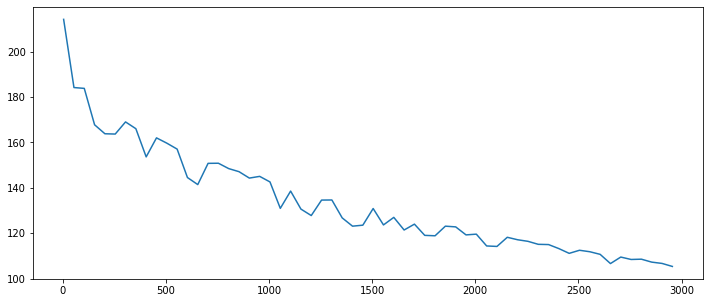

In [97]:
plt.figure(figsize=(12, 5))
plt.plot(list(range(5, 3000, 50)), scores)

В реальности метод локтя работает так себе (где на картинке локоть сказать сложно). И честным ответом на "как найти оптимальное количество кластеров" будет - а спросите что-нибудь попроще.

## Домашнее задание

1. На нескольких алгоритмах кластеризации, умеющих работать с sparse матрицами, проверьте, что работает лучше Count_Vectorizer или TfidfVectorizer (попробуйте выжать максимум из каждого - попробуйте нграммы, символьные нграммы, разные значения max_features и min_df) (3 балла)

2. На нескольких алгоритмах кластеризации проверьте, какое матричное разложение (TruncatedSVD или NMF) работает лучше для кластеризации. (3 балла)

3. С помощью алгоритмов, умеющих выделять выбросы, попробуйте найти необычные объявления (необычные - это такие, которые непонятно к какой категории можно вообще отнести, что-то с ошибками или вообще какая-то дичь). В этом задании можно использовать любую векторизацию. (4 балла)

Используйте те же данные, что и в семинаре (колонки - title и category_name)

Делайте соответствующие вашими ресурсам и потребностям алгоритма подвыборки из всего датасета. Для сравнения используйте любую из метрик, которые есть в семинаре. Оценивать на глаз тоже можно, но тогда нужно объяснить, почему вы считаете одну кластеризацию лучше. 

НЕ ЗАБЫВАЙТЕ подбирать параметры в кластеризации. **За использование всех параметров по умолчанию, оценка будет снижаться** (под использованием всех параметров по умолчанию я имею в виду что-то такое -  `cluster = DBSCAN()`) 

Если получится, используйте метод локтя. (1 бонусный балл)

## Мое решение

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [7]:
data = pd.read_csv('clustering/data.csv')

## Задание 1

In [8]:
sample = data.sample(frac=0.1)

In [9]:
sample.shape

(25422, 17)

In [10]:
cv = CountVectorizer(max_features=650)
X = cv.fit_transform(sample['title'])
y = sample['category_name']

In [11]:
tf = TfidfVectorizer(min_df=20, max_df=0.9, max_features=900)
X_2 = tf.fit_transform(sample['title'])
y_2 = sample['category_name']

## KMeans

In [12]:
cluster = KMeans(n_clusters=47, n_init=15)
cluster.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=47, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
cluster_2 = KMeans(n_clusters=47, n_init=15)
cluster_2.fit(X_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=47, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
labels = cluster.labels_

In [15]:
labels_2 = cluster_2.labels_

In [16]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X[:10000], labels[:10000]))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) 
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

Silhouette Coefficient: 0.167
Homogeneity: 0.264
Completeness: 0.387
V-measure: 0.314
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.303


In [17]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_2[:10000], labels_2[:10000]))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_2, labels_2)) 
print("Completeness: %0.3f" % metrics.completeness_score(y_2, labels_2)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y_2, labels_2))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_2, labels_2))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_2, labels_2))

Silhouette Coefficient: 0.233
Homogeneity: 0.258
Completeness: 0.353
V-measure: 0.298
Adjusted Rand Index: -0.013
Adjusted Mutual Information: 0.287


## MiniBatchKMeans

In [18]:
cluster = MiniBatchKMeans(n_clusters=800, init_size=4000, verbose=1, max_iter=3000, 
                          max_no_improvement=75, reassignment_ratio=0.5)
cluster.fit(X)

Init 1/3 with method: k-means++
Inertia for init 1/3: 2105.216134
Init 2/3 with method: k-means++
Inertia for init 2/3: 2073.865962
Init 3/3 with method: k-means++
Inertia for init 3/3: 2117.344476
Minibatch iteration 1/765000: mean batch inertia: 0.574299, ewa inertia: 0.574299 
Minibatch iteration 2/765000: mean batch inertia: 0.652154, ewa inertia: 0.574911 
Minibatch iteration 3/765000: mean batch inertia: 0.695046, ewa inertia: 0.575856 
Minibatch iteration 4/765000: mean batch inertia: 0.565176, ewa inertia: 0.575772 
Minibatch iteration 5/765000: mean batch inertia: 0.844911, ewa inertia: 0.577890 
Minibatch iteration 6/765000: mean batch inertia: 0.670501, ewa inertia: 0.578618 
Minibatch iteration 7/765000: mean batch inertia: 0.717006, ewa inertia: 0.579707 
Minibatch iteration 8/765000: mean batch inertia: 0.688490, ewa inertia: 0.580563 
Minibatch iteration 9/765000: mean batch inertia: 0.836904, ewa inertia: 0.582579 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minib

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=4000, max_iter=3000, max_no_improvement=75,
                n_clusters=800, n_init=3, random_state=None,
                reassignment_ratio=0.5, tol=0.0, verbose=1)

In [19]:
cluster_2 = MiniBatchKMeans(n_clusters=800, init_size=4000, verbose=1, max_iter=3000, 
                          max_no_improvement=75, reassignment_ratio=0.5)
cluster_2.fit(X_2)

Init 1/3 with method: k-means++
Inertia for init 1/3: 510.694253
Init 2/3 with method: k-means++
Inertia for init 2/3: 529.042521
Init 3/3 with method: k-means++
Inertia for init 3/3: 519.821745
Minibatch iteration 1/765000: mean batch inertia: 0.207477, ewa inertia: 0.207477 
Minibatch iteration 2/765000: mean batch inertia: 0.159972, ewa inertia: 0.207103 
Minibatch iteration 3/765000: mean batch inertia: 0.133681, ewa inertia: 0.206526 
Minibatch iteration 4/765000: mean batch inertia: 0.219974, ewa inertia: 0.206631 
Minibatch iteration 5/765000: mean batch inertia: 0.249078, ewa inertia: 0.206965 
Minibatch iteration 6/765000: mean batch inertia: 0.205968, ewa inertia: 0.206958 
Minibatch iteration 7/765000: mean batch inertia: 0.237985, ewa inertia: 0.207202 
Minibatch iteration 8/765000: mean batch inertia: 0.202547, ewa inertia: 0.207165 
Minibatch iteration 9/765000: mean batch inertia: 0.205351, ewa inertia: 0.207151 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatc

Minibatch iteration 142/765000: mean batch inertia: 0.139533, ewa inertia: 0.185742 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 143/765000: mean batch inertia: 0.139610, ewa inertia: 0.185379 
Minibatch iteration 144/765000: mean batch inertia: 0.169440, ewa inertia: 0.185254 
Minibatch iteration 145/765000: mean batch inertia: 0.177099, ewa inertia: 0.185190 
Minibatch iteration 146/765000: mean batch inertia: 0.157021, ewa inertia: 0.184968 
Minibatch iteration 147/765000: mean batch inertia: 0.196382, ewa inertia: 0.185058 
Minibatch iteration 148/765000: mean batch inertia: 0.172209, ewa inertia: 0.184957 
Minibatch iteration 149/765000: mean batch inertia: 0.218009, ewa inertia: 0.185217 
Minibatch iteration 150/765000: mean batch inertia: 0.181358, ewa inertia: 0.185187 
Minibatch iteration 151/765000: mean batch inertia: 0.196655, ewa inertia: 0.185277 
Minibatch iteration 152/765000: mean batch inertia: 0.188963, ewa inertia: 0.185306 
Minibatch itera

Minibatch iteration 280/765000: mean batch inertia: 0.151184, ewa inertia: 0.170644 
Minibatch iteration 281/765000: mean batch inertia: 0.162695, ewa inertia: 0.170581 
Minibatch iteration 282/765000: mean batch inertia: 0.191781, ewa inertia: 0.170748 
Minibatch iteration 283/765000: mean batch inertia: 0.216888, ewa inertia: 0.171111 
Minibatch iteration 284/765000: mean batch inertia: 0.185352, ewa inertia: 0.171223 
Minibatch iteration 285/765000: mean batch inertia: 0.196212, ewa inertia: 0.171420 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 286/765000: mean batch inertia: 0.143297, ewa inertia: 0.171199 
Minibatch iteration 287/765000: mean batch inertia: 0.165499, ewa inertia: 0.171154 
Minibatch iteration 288/765000: mean batch inertia: 0.149021, ewa inertia: 0.170980 
Minibatch iteration 289/765000: mean batch inertia: 0.148695, ewa inertia: 0.170804 
Minibatch iteration 290/765000: mean batch inertia: 0.167192, ewa inertia: 0.170776 
Minibatch itera

Minibatch iteration 423/765000: mean batch inertia: 0.194331, ewa inertia: 0.168528 
Minibatch iteration 424/765000: mean batch inertia: 0.195855, ewa inertia: 0.168743 
Minibatch iteration 425/765000: mean batch inertia: 0.186440, ewa inertia: 0.168882 
Minibatch iteration 426/765000: mean batch inertia: 0.168819, ewa inertia: 0.168881 
Minibatch iteration 427/765000: mean batch inertia: 0.143702, ewa inertia: 0.168683 
Minibatch iteration 428/765000: mean batch inertia: 0.182284, ewa inertia: 0.168790 
Minibatch iteration 429/765000: mean batch inertia: 0.165090, ewa inertia: 0.168761 
Minibatch iteration 430/765000: mean batch inertia: 0.166510, ewa inertia: 0.168744 
Minibatch iteration 431/765000: mean batch inertia: 0.171588, ewa inertia: 0.168766 
Minibatch iteration 432/765000: mean batch inertia: 0.175266, ewa inertia: 0.168817 
Minibatch iteration 433/765000: mean batch inertia: 0.143478, ewa inertia: 0.168618 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch itera

Minibatch iteration 547/765000: mean batch inertia: 0.165411, ewa inertia: 0.167488 
Minibatch iteration 548/765000: mean batch inertia: 0.166944, ewa inertia: 0.167484 
Minibatch iteration 549/765000: mean batch inertia: 0.231167, ewa inertia: 0.167985 
Minibatch iteration 550/765000: mean batch inertia: 0.167147, ewa inertia: 0.167978 
Minibatch iteration 551/765000: mean batch inertia: 0.135842, ewa inertia: 0.167725 
Minibatch iteration 552/765000: mean batch inertia: 0.165889, ewa inertia: 0.167711 
Minibatch iteration 553/765000: mean batch inertia: 0.202548, ewa inertia: 0.167985 
Minibatch iteration 554/765000: mean batch inertia: 0.178186, ewa inertia: 0.168065 
Minibatch iteration 555/765000: mean batch inertia: 0.178066, ewa inertia: 0.168144 
Minibatch iteration 556/765000: mean batch inertia: 0.166273, ewa inertia: 0.168129 
Minibatch iteration 557/765000: mean batch inertia: 0.242871, ewa inertia: 0.168717 
Minibatch iteration 558/765000: mean batch inertia: 0.151100, ewa

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=4000, max_iter=3000, max_no_improvement=75,
                n_clusters=800, n_init=3, random_state=None,
                reassignment_ratio=0.5, tol=0.0, verbose=1)

In [20]:
labels = cluster.labels_

In [21]:
labels_2 = cluster_2.labels_

In [22]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X[:10000], labels[:10000]))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) 
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

Silhouette Coefficient: 0.413
Homogeneity: 0.542
Completeness: 0.328
V-measure: 0.409
Adjusted Rand Index: 0.003
Adjusted Mutual Information: 0.346


In [23]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_2[:10000], labels_2[:10000]))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_2, labels_2)) 
print("Completeness: %0.3f" % metrics.completeness_score(y_2, labels_2)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y_2, labels_2))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_2, labels_2))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_2, labels_2))

Silhouette Coefficient: 0.578
Homogeneity: 0.600
Completeness: 0.334
V-measure: 0.429
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.361


## AffinityPropagation

С текущими настройками CountVectorizer и TfidfVectorizer кернел умирает снова и снова, поэтому я их поменяю.

In [24]:
sample = data.sample(frac=0.01)

In [25]:
cv = CountVectorizer(min_df=2, max_df=0.55, max_features=700)
X = cv.fit_transform(sample['title'])
y = sample['category_name']

In [26]:
tf = TfidfVectorizer(max_df=0.8, max_features=500)
X_2 = tf.fit_transform(sample['title'])
y_2 = sample['category_name']

In [32]:
cluster = AffinityPropagation(damping=0.5, preference=-7, 
                              max_iter=800, verbose=1)
cluster.fit(X)

Converged after 525 iterations.


AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=800, preference=-7, verbose=1)

In [33]:
cluster_2 = AffinityPropagation(damping=0.5, preference=-7, 
                              max_iter=800, verbose=1)
cluster_2.fit(X_2)

Did not converge


AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=800, preference=-7, verbose=1)

Почему-то второй вариант не сходится, несмотря на изменения параметров в TfidfVectorizer и в самой кластеризации.

In [34]:
labels = cluster.labels_

In [35]:
labels_2 = cluster_2.labels_

In [36]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X[:10000], labels[:10000]))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) 
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

Silhouette Coefficient: 0.190
Homogeneity: 0.398
Completeness: 0.397
V-measure: 0.398
Adjusted Rand Index: -0.004
Adjusted Mutual Information: 0.295


## Задание 2

## AgglomerativeClustering

In [37]:
sample = data.sample(frac=0.05)

In [38]:
cv = CountVectorizer(max_features=2000)

In [39]:
svd = TruncatedSVD(50, random_state=0)

In [40]:
X = cv.fit_transform(sample['title'])

In [41]:
X_svd = svd.fit_transform(X)
y_svd = sample['category_name']

In [42]:
nmf = NMF(50, random_state=0)

In [43]:
X_nmf = nmf.fit_transform(X)
y_nmf = sample['category_name']

In [44]:
cluster_svd = AgglomerativeClustering(n_clusters=47)
cluster_svd.fit(X_svd)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=47)

In [45]:
cluster_nmf = AgglomerativeClustering(n_clusters=47)
cluster_nmf.fit(X_nmf)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=47)

In [46]:
labels_svd = cluster_svd.labels_

In [47]:
labels_nmf = cluster_nmf.labels_

In [48]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_svd[:10000], labels_svd[:10000]))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_svd, labels_svd)) 
print("Completeness: %0.3f" % metrics.completeness_score(y_svd, labels_svd)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y_svd, labels_svd))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_svd, labels_svd))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_svd, labels_svd))

Silhouette Coefficient: 0.676
Homogeneity: 0.300
Completeness: 0.376
V-measure: 0.334
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.313


In [49]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_nmf[:10000], labels_nmf[:10000]))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_nmf, labels_nmf)) 
print("Completeness: %0.3f" % metrics.completeness_score(y_nmf, labels_nmf)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y_nmf, labels_nmf))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_nmf, labels_nmf))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_nmf, labels_nmf))

Silhouette Coefficient: 0.713
Homogeneity: 0.288
Completeness: 0.359
V-measure: 0.320
Adjusted Rand Index: -0.004
Adjusted Mutual Information: 0.298


## MeanShift

In [50]:
sample = data.sample(frac=0.01)

In [51]:
cluster_svd = MeanShift(cluster_all=False, bandwidth=0.75, max_iter=150)
cluster_svd.fit(X_svd)

MeanShift(bandwidth=0.75, bin_seeding=False, cluster_all=False, max_iter=150,
          min_bin_freq=1, n_jobs=None, seeds=None)

In [52]:
cluster_nmf = MeanShift(cluster_all=False, bandwidth=0.75, max_iter=150)
cluster_nmf.fit(X_nmf)

MeanShift(bandwidth=0.75, bin_seeding=False, cluster_all=False, max_iter=150,
          min_bin_freq=1, n_jobs=None, seeds=None)

In [53]:
labels_svd = cluster_svd.labels_

In [54]:
labels_nmf = cluster_nmf.labels_

In [55]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_svd[:10000], labels_svd[:10000]))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_svd, labels_svd)) 
print("Completeness: %0.3f" % metrics.completeness_score(y_svd, labels_svd)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y_svd, labels_svd))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_svd, labels_svd))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_svd, labels_svd))

Silhouette Coefficient: 0.759
Homogeneity: 0.315
Completeness: 0.337
V-measure: 0.325
Adjusted Rand Index: -0.007
Adjusted Mutual Information: 0.267


In [56]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_nmf, labels_nmf))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_nmf, labels_nmf)) 
print("Completeness: %0.3f" % metrics.completeness_score(y_nmf, labels_nmf)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y_nmf, labels_nmf))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_nmf, labels_nmf))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_nmf, labels_nmf))

Silhouette Coefficient: 0.689
Homogeneity: 0.001
Completeness: 0.523
V-measure: 0.002
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.001


По какой-то причине вторая кластеризация не считает метрики и сообщает ошибку о количестве лейблов.

## DBSCAN

In [57]:
sample = data.sample(frac=0.05)

In [58]:
cluster_svd = DBSCAN(min_samples=15, eps=0.4) 
cluster_svd.fit(X_svd)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=15, n_jobs=None, p=None)

In [59]:
cluster_nmf = DBSCAN(min_samples=15, eps=0.4) 
cluster_nmf.fit(X_nmf)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=15, n_jobs=None, p=None)

In [60]:
labels_svd = cluster_svd.labels_

In [61]:
labels_nmf = cluster_nmf.labels_

In [62]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_svd, labels_svd))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_svd, labels_svd)) 
print("Completeness: %0.3f" % metrics.completeness_score(y_svd, labels_svd)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y_svd, labels_svd))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_svd, labels_svd))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_svd, labels_svd))

Silhouette Coefficient: 0.627
Homogeneity: 0.271
Completeness: 0.338
V-measure: 0.301
Adjusted Rand Index: -0.008
Adjusted Mutual Information: 0.272


In [63]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_nmf, labels_nmf))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_nmf, labels_nmf)) 
print("Completeness: %0.3f" % metrics.completeness_score(y_nmf, labels_nmf)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y_nmf, labels_nmf))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_nmf, labels_nmf))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y_nmf, labels_nmf))

Silhouette Coefficient: 0.606
Homogeneity: 0.004
Completeness: 0.633
V-measure: 0.008
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.007


## Задание 3

In [76]:
sample = data.sample(frac=0.05)

In [77]:
y = sample['category_name']

In [78]:
cv = CountVectorizer(min_df=5, max_df=0.5, max_features=1000)

In [79]:
Х = cv.fit_transform(sample['title'])

In [80]:
svd = TruncatedSVD(50, random_state=0)

In [81]:
X_svd = svd.fit_transform(X)

In [82]:
outliers = DBSCAN(min_samples=6, eps=0.7)

In [83]:
outliers.fit(X)

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=6, n_jobs=None, p=None)

In [84]:
labels = outliers.labels_

In [85]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_svd, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) 
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) 
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

Silhouette Coefficient: -0.265
Homogeneity: 0.068
Completeness: 0.108
V-measure: 0.083
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.002


In [88]:
sample['outliers'] = labels

In [89]:
sample.loc[sample.outliers == -1].head(20)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,outliers
217089,366f050a5d77,5735ee0fd250,Башкортостан,Уфа,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,Продам телевизор,Продам телевизор РОЛСОН диагональ 70 см в рабо...,2000.0,32,2017-04-13,Private,04b32a84e765d650741dd7bd3cfaa0b478a7704b3bbf27...,3022.0,-1
97378,43c2073cd99e,f6cd44e7c0b4,Свердловская область,Екатеринбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,36,Туфли,"Туфли из натуральной кожи, 36 р",400.0,53,2017-04-16,Private,abbe79b0cc747cd867e9ac8f341ef166ca777c7bf57141...,432.0,-1
143100,23ef73fbf2fd,4a59d49f2b6c,Красноярский край,Норильск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,Без размера,Шапка норковая,"Новая,совсем не носилась.Покупал жене в подаро...",10000.0,4,2017-04-13,Private,09d0e10be9d6b392abc49fb1ed485808918e00d14bf677...,227.0,-1
133819,b7c22a71fcf1,edde477d7916,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Верхняя одежда,110-116 см (4-6 лет),Ветровочка,"на девочку, новая, состояние отличное./\n+джин...",300.0,47,2017-04-18,Private,34123d749bbf54082f80ec7c616e9b283411ed39f82d6d...,97.0,-1
173923,1b3652b39cde,6250d89a2988,Ставропольский край,Кисловодск,Хобби и отдых,Охота и рыбалка,NaN,NaN,NaN,Выползки для рыбалки Крупные,Продам выползков 5 р шт.,5.0,31,2017-04-15,Private,NaN,NaN,-1
50994,c012c6596a47,898f982d5e25,Кемеровская область,Кемерово,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,37,Кожаные полусапожки,"Нат кожа, модные, стильные. Б/у несколько раз,...",1200.0,123,2017-04-18,Company,9fbc1a74ee6bbd88b62d3669504ab78b95cb950b578af3...,642.0,-1
168373,82ddfac71823,3b066e54189e,Самарская область,Чапаевск,Хобби и отдых,Велосипеды,Горные,NaN,NaN,Велосипед Stinger SX 100 Matrix,Велосипед куплен 02.07.15г. Эксплуатировался 2...,9000.0,10,2017-04-12,Private,8cd2638e8baee77ed1ff45ebf5f6588793e6bb487040f7...,2368.0,-1
222919,fc96ba20eb29,17e43ac638ea,Ставропольский край,Ставрополь,Хобби и отдых,Музыкальные инструменты,Для студии и концертов,NaN,NaN,Микшерный пульт Электроника пм-01,Продается микшерный пульт Электроника ПМ-01 в ...,5000.0,6,2017-04-13,Private,19bba892aef6710727976b01a71d86b8ed0ea8b0c39ffa...,2492.0,-1
250797,51c897541c6d,494a16a6bea0,Свердловская область,Екатеринбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Нижнее бельё,44–46 (M),Сетка эротическая новая 42-48,Универсальный размер 42-48. Смотреть/забирать ...,500.0,252,2017-04-14,Company,e6b16db7f9596c9e1249cea98040e5bcf81632bfedbe0c...,553.0,-1
166817,b96797c14349,4b9c28a56185,Башкортостан,Уфа,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Рубашки и блузки,40–42 (XS),Женская шифоновая блуза,"Лёгкая, шифоновая блуза. Рукава 3/4 , подол у...",600.0,7,2017-04-14,Private,a5fd1c1cfcef433e7261d061b1bdd9ba1615accfabb3d6...,415.0,-1


Особо заметных отклонений не видно.